In [1]:
# aca basicamente vamos a estar incluyendo todas nuestras librerias/codigos externos que nos puedan ayudar.
import numpy as np # lo usamos para hacer calculos matriciales, normalmente para hacer procesamiento de nuestras imagenes (Matrices 3D)
import pandas as pd # para poder manejar nuestros datos de manera mas rapida.
import matplotlib.pyplot as plt # para poder imprimir graficas con nuestros datos
import os # operating system library
from sklearn.model_selection import train_test_split # para poder separar nuestros datos en entrenamiento y en testeo para medir los results
import tensorflow as tf # libreria para todo lo que seria modelos de deteccion y ML
import keras # tambien para los modelos de ML 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import cv2 # computer vision.
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
Lung_Opacity = ['./Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity'] # ruta a las imagenes : Lung opacity
Normal = ['./Lung X-Ray Image/Lung X-Ray Image/Normal'] # ruta a las imagene : Normal
Viral_Pneumonia = ['./Lung X-Ray Image/Lung X-Ray Image/Viral Pneumonia']# ruta a las imagene : Neumonia.
file_p = [] # en este array vamos a guardar la ruta a cada archivo.
labels = [] # En este array vamos a guardar las etiquetas para cada archivo
dict_lists = [Normal, Lung_Opacity,Viral_Pneumonia] # una lista de listas
class_labels = ['Normal', 'Lung Opacity','Viral Pneumonia'] # los lables.

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath) # añadimos la ruta al archivo 
                labels.append(class_labels[i]) # para ese mismo index le agregamos la etiqueta.


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data) # creamos nuestro dataframe uniendo las dos series.

In [3]:
df.head(5) # imprimimos los primeros 5 elementos en nuestro diccionario

,filepaths,labels
0,./Lung X-Ray Image/Lung X-Ray Image/Normal/63.jpg,Normal
1,./Lung X-Ray Image/Lung X-Ray Image/Normal/823...,Normal
2,./Lung X-Ray Image/Lung X-Ray Image/Normal/189...,Normal
3,./Lung X-Ray Image/Lung X-Ray Image/Normal/77.jpg,Normal
4,./Lung X-Ray Image/Lung X-Ray Image/Normal/837...,Normal


In [4]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels) # esto lo usamos para evitar overfitting.
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape) #dividimos nuestros datos,
print(val_df.shape)

(2215, 2)
(869, 2)
(391, 2)


In [5]:
def enhance_image(image): #Resaltar detalles importantes en las imágenes de rayos X para facilitar que un modelo de deep learning (como InceptionV3) detecte anomalías como opacidades pulmonares o signos de neumonía.
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0) # Ajuste de contraste

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) #Filtro de realce de bordes
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2215 validated image filenames belonging to 3 classes.
Found 869 validated image filenames belonging to 3 classes.
Found 391 validated image filenames belonging to 3 classes.


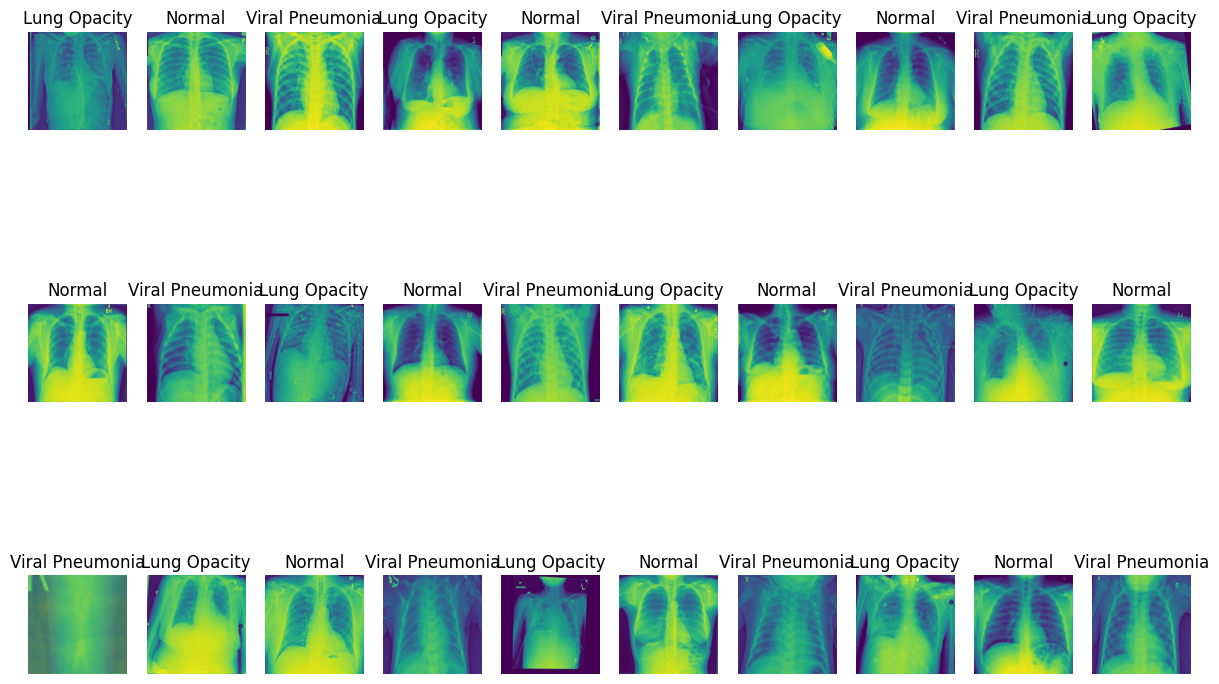

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [8]:
!/Applications/Python\ 3.12/Install\ Certificates.command


 -- pip install --upgrade certifi

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


In [9]:
#aca entrenamos el modelo, con nuestros datos, hay que tener en cuenta que los pesos ya estan predefinididos, lo que nos ahorra mucho tiempo, pero podriamos ver para reajustar los hiperparametros/pesos.
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax

# Load pre-trained MobileNet model without the top (fully connected) layers
base_model = MobileNet(weights=None, include_top=False, input_shape=(256, 256, 3), pooling='max')
base_model.load_weights('./models/mobilenet_weights.h5')


# Add custom top layers for your specific task
x = base_model.output
x = BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7339 - loss: 0.6775 - val_accuracy: 0.6496 - val_loss: 1.0112
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2251s 33s/step - accuracy: 0.9368 - loss: 0.1669 - val_accuracy: 0.8363 - val_loss: 0.5429
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1201s 17s/step - accuracy: 0.9829 - loss: 0.0713 - val_accuracy: 0.9028 - val_loss: 0.3174
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1736s 25s/step - accuracy: 0.9969 - loss: 0.0229 - val_accuracy: 0.9130 - val_loss: 0.2439
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2865s 42s/step - accuracy: 0.9987 - loss: 0.0104 - val_accuracy: 0.9054 - val_loss: 0.2655
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2029s 29s/step - accuracy: 0.9993 - loss: 0.0072 - val_accuracy: 0.9182 - val_loss: 0.2540
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1954s 28s/step - accuracy: 0.9997 - loss: 0.0052 - val_accuracy: 0.9207 - val_loss: 0.2751
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8190s 119s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9182

In [13]:
# para guardar todo una vez termine:

In [14]:
import os
import pickle
import numpy as np

# Crear carpeta 'models' si no existe
if not os.path.exists('models'):
    os.makedirs('models')

# 1. Guardar el modelo completo
model.save('models/pulmon_disease_model.h5')

# 2. Guardar solo los pesos
model.save_weights('models/pulmon_disease_weights.weights.h5')

# 3. Guardar la arquitectura en JSON
model_json = model.to_json()
with open('models/pulmon_disease_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# 4. Guardar el historial del entrenamiento
with open('models/pulmon_disease_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# 5. Guardar la matriz de confusión
np.save('models/pulmon_disease_confusion_matrix.npy', conf_matrix)


In [15]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9183 - loss: 0.3680
Test Loss: 0.34331896901130676
Test Accuracy: 0.9205983877182007


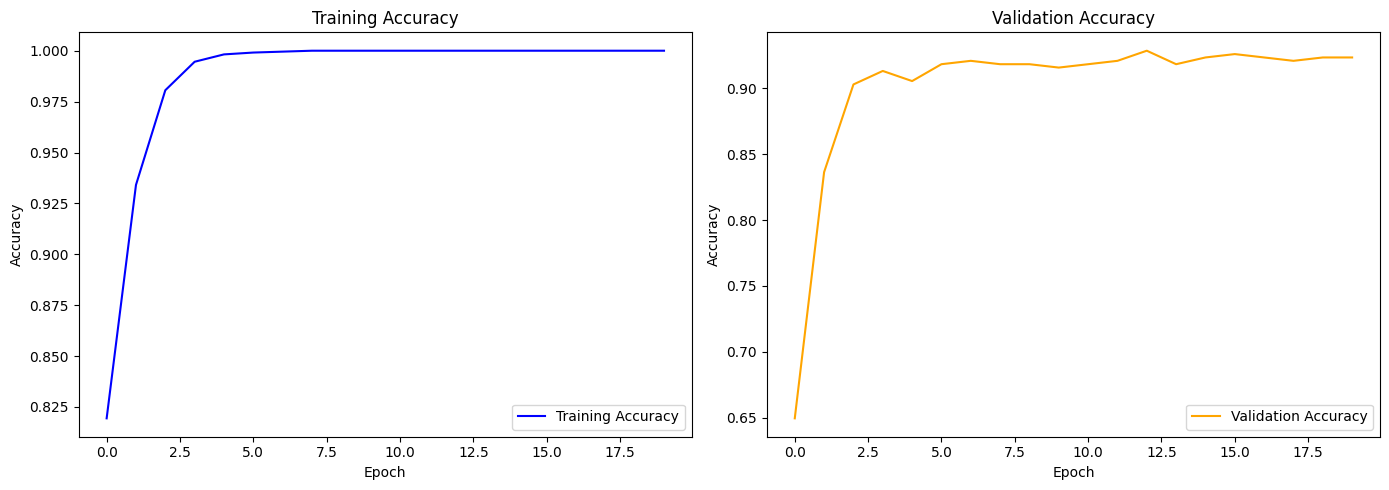

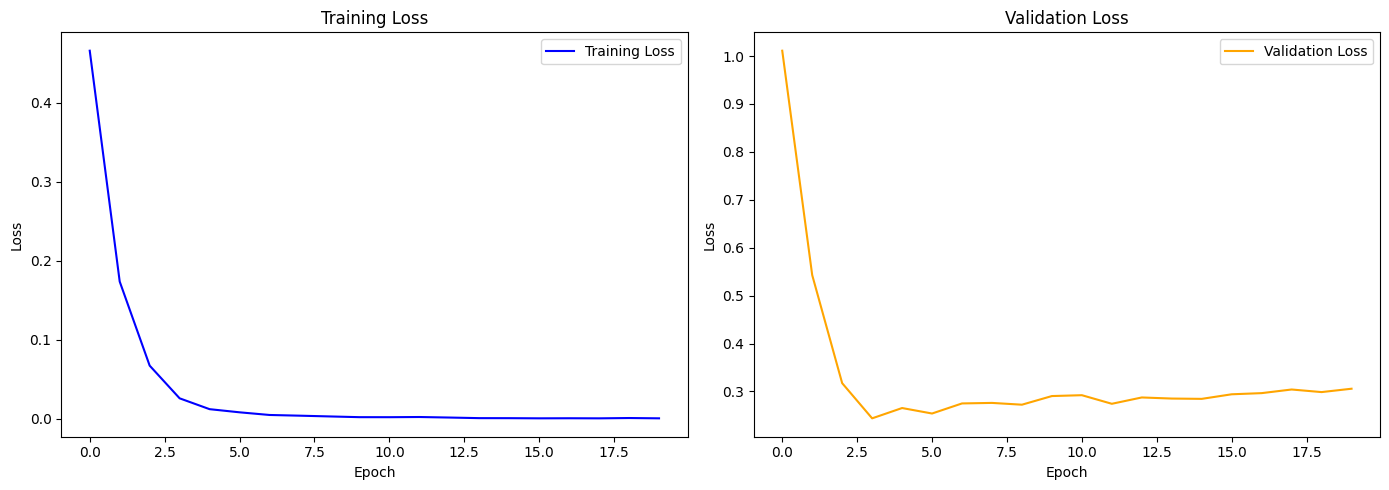

In [16]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step


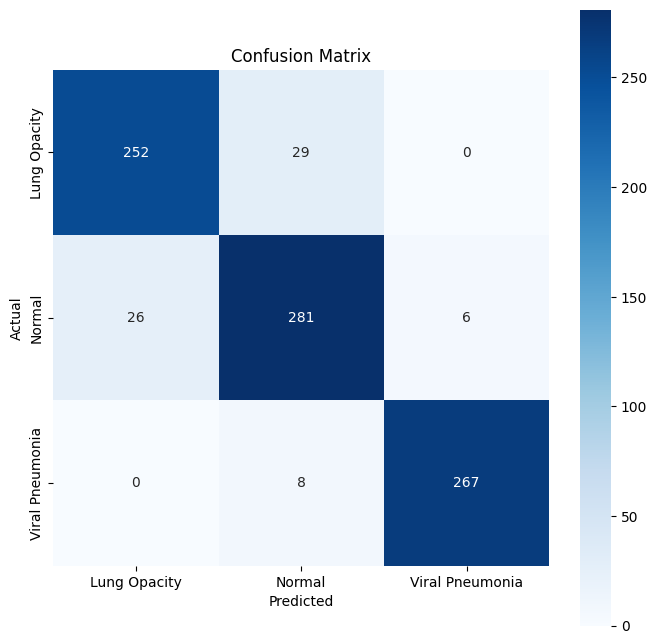

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Esa imagen nos muestra que hay un total de 69 falsos negativos / falsos positivos.
#mientas que tenemos una cantidad de  : 800 verdaderos positivos y verdaderos negativos. 